In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
scl=StandardScaler()
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_selection import SelectKBest, chi2

#### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [77]:
path_brent = 'my_BRENT2019.csv'
df = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
Значение           2667 non-null float64
year               2667 non-null int64
month              2667 non-null int64
dayofmonth         2667 non-null int64
quarter            2667 non-null int64
dayofyear          2667 non-null int64
weekofyear         2667 non-null int64
dayofweek          2667 non-null int64
is_holiday         2667 non-null int64
is_prev_holiday    2667 non-null int64
is_next_holiday    2667 non-null int64
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


Text(0.5, 0, 't')

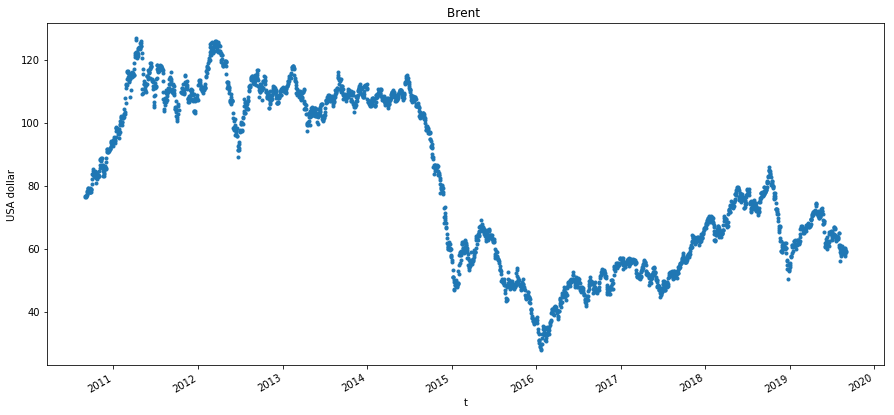

In [79]:
_ = df['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Вопрос - нужно ли работать с пропусками в датах, так как это время не работы биржи?

#### 2. Добавьте первые разности по стоимости доллара и евро к рублю 


In [80]:
data_dollar = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx',  parse_dates = {'Date' : [0]}, usecols=[1,2])
data_dollar.set_index('Date', inplace=True)
data_dollar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 1 columns):
curs    2228 non-null float64
dtypes: float64(1)
memory usage: 34.8 KB


In [81]:
data_euro = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx',  parse_dates = {'Date' : [0]}, usecols=[1,2])
data_euro.set_index('Date', inplace=True)
data_euro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 1 columns):
curs    2228 non-null float64
dtypes: float64(1)
memory usage: 34.8 KB


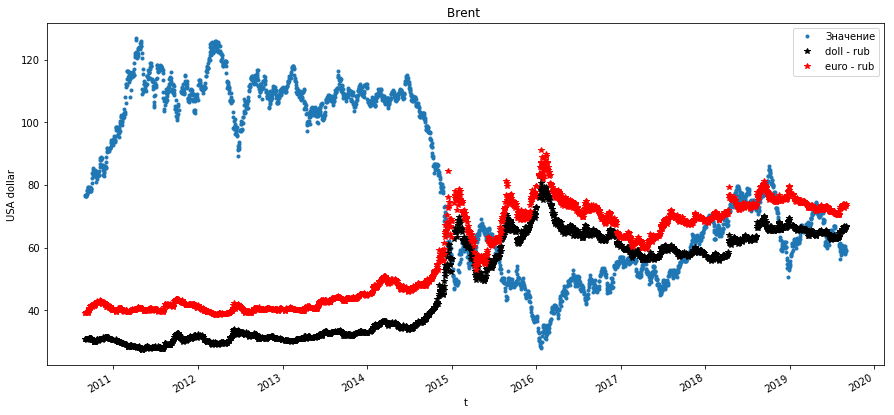

In [82]:
_ = df['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(data_dollar.index,data_dollar['curs'].values,'*k', label='doll - rub')
plt.plot(data_euro.index,data_euro['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

##### Анализа пропусков в данных по нефти и курсам и запонялем пропущенные значения (не уверена что это нужно)

In [83]:
dates_empty_list = pd.date_range(df.index.min(), df.index.max(), freq="D")
diff_list = set(dates_empty_list) - set(df.index.unique())
print(f'Количество пропущенных дней: {len(diff_list)}')

Количество пропущенных дней: 621


In [84]:
df['date'] = df.index
count_data = df['date'].value_counts()
mask = count_data.values != 1
notvalid_days = pd.Series(count_data.values[mask], count_data.index[mask])
notvalid_days

Series([], dtype: int64)

In [85]:
full_data = pd.DataFrame(dates_empty_list, columns=['Date'], index=dates_empty_list)
full_data = full_data.join(df, on='Date', how='left')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 13 columns):
Date               3288 non-null datetime64[ns]
Значение           2667 non-null float64
year               2667 non-null float64
month              2667 non-null float64
dayofmonth         2667 non-null float64
quarter            2667 non-null float64
dayofyear          2667 non-null float64
weekofyear         2667 non-null float64
dayofweek          2667 non-null float64
is_holiday         2667 non-null float64
is_prev_holiday    2667 non-null float64
is_next_holiday    2667 non-null float64
date               2667 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(11)
memory usage: 359.6 KB


In [86]:
def prepare_data(df):
    df['is_na'] = 0
    df.loc[df['Значение'].isna(), ['is_na']] = 1
    df['weekofyear'] = df['Date'].dt.weekofyear
    df.fillna(method='pad', inplace=True)
    return df

In [87]:
full_data = prepare_data(full_data)
full_data.info()
del df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 14 columns):
Date               3288 non-null datetime64[ns]
Значение           3288 non-null float64
year               3288 non-null float64
month              3288 non-null float64
dayofmonth         3288 non-null float64
quarter            3288 non-null float64
dayofyear          3288 non-null float64
weekofyear         3288 non-null int64
dayofweek          3288 non-null float64
is_holiday         3288 non-null float64
is_prev_holiday    3288 non-null float64
is_next_holiday    3288 non-null float64
date               3288 non-null datetime64[ns]
is_na              3288 non-null int64
dtypes: datetime64[ns](2), float64(10), int64(2)
memory usage: 385.3 KB


In [88]:
def add_first_diff(df, feature=0):
    first_diff =np.array(df.iloc[1:,feature].values - df.iloc[:-1,feature].values).astype('float32') 
    return df

In [89]:
full_data = add_first_diff(full_data, 1)
full_data.head()

,Date,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,date,is_na
2010-09-01,2010-09-01,76.37,2010.0,9.0,1.0,3.0,244.0,35,2.0,0.0,0.0,0.0,2010-09-01,0
2010-09-02,2010-09-02,76.89,2010.0,9.0,2.0,3.0,245.0,35,3.0,0.0,0.0,0.0,2010-09-02,0
2010-09-03,2010-09-03,76.57,2010.0,9.0,3.0,3.0,246.0,35,4.0,0.0,0.0,0.0,2010-09-03,0
2010-09-04,2010-09-04,76.62,2010.0,9.0,4.0,3.0,247.0,35,5.0,0.0,0.0,0.0,2010-09-04,0
2010-09-05,2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35,6.0,0.0,1.0,0.0,2010-09-05,0


Проверяем данные по курсам валют

In [90]:
def add_currency_data(data, full_list_date):
    df = pd.DataFrame(full_list_date, columns=['Date'], index=full_list_date)
    df = df.join(data, on='Date', how='left')
    df['is_na'] = 0
    df.loc[df['curs'].isna(), ['is_na']] = 1
    df.fillna(method='pad', inplace=True)
    return df

In [91]:
data_euro = add_currency_data(data_euro, dates_empty_list)
data_euro = add_first_diff(data_euro, 1)
data_euro.rename(columns={'curs':'curs_euro', 'is_na':'is_na_euro'}, inplace=True)
data_euro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 3 columns):
Date          3288 non-null datetime64[ns]
curs_euro     3288 non-null float64
is_na_euro    3288 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 102.8 KB


In [92]:
data_dollar = add_currency_data(data_dollar, dates_empty_list)
data_dollar = add_first_diff(data_dollar, 1)
data_dollar.rename(columns={'curs':'curs_dollar', 'is_na':'is_na_dollar'}, inplace=True)
data_dollar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 3 columns):
Date            3288 non-null datetime64[ns]
curs_dollar     3288 non-null float64
is_na_dollar    3288 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 102.8 KB


#### 3. Cделайте ее перрасчет (ресемплинг) в представление по неделям.


In [93]:
df = pd.merge(full_data, data_euro, left_index=True, right_index=True)
df = pd.merge(df, data_dollar, left_index=True, right_index=True)
df_w = df.resample('W').mean()
df_w.index.name = 'Date'
df_w = df_w.dropna()
df_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,is_na,curs_euro,is_na_euro,curs_dollar,is_na_dollar
Date,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.000000,39.233840,0.200000,30.747440,0.200000
2010-09-12,77.771429,2010.0,9.000000,8.857143,3.000000,251.857143,36.0,2.857143,0.142857,0.0,0.142857,0.142857,39.287000,0.285714,30.793714,0.285714
2010-09-19,78.590000,2010.0,9.000000,15.857143,3.000000,258.857143,37.0,2.857143,0.000000,0.0,0.000000,0.142857,39.984557,0.285714,30.887129,0.285714
2010-09-26,78.558571,2010.0,9.000000,22.857143,3.000000,265.857143,38.0,2.857143,0.000000,0.0,0.000000,0.142857,41.040657,0.285714,31.003800,0.285714
2010-10-03,81.582857,2010.0,9.428571,17.000000,3.428571,272.857143,39.0,2.857143,0.000000,0.0,0.000000,0.142857,41.382686,0.285714,30.585086,0.285714


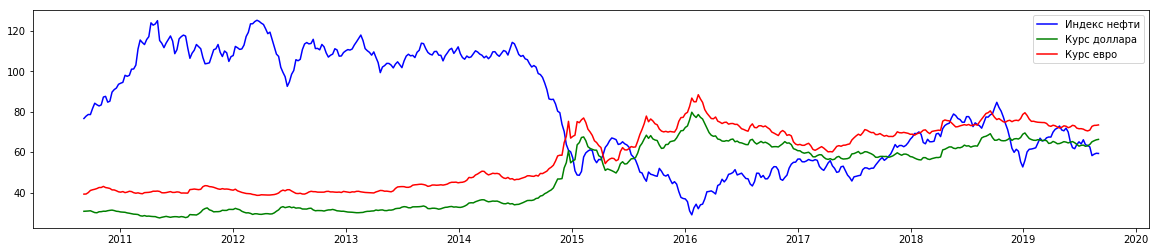

In [94]:
plt.figure(figsize =(20,4))
plt.plot(df_w.index, df_w['Значение'], 'b', label='Индекс нефти' )
plt.plot(df_w.index, df_w['curs_dollar'], 'g', label='Курс доллара' )
plt.plot(df_w.index, df_w['curs_euro'], 'r', label='Курс евро' )
plt.legend()
plt.show()

#### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [95]:
# функция разбиения датасета на тестовую и валидационную выборки 
def split_data_b( data, split_date ):
    data = data[['Значение', 't', 't1', 't2', 'curs_dollar', 'curs_euro']]
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
          data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [96]:
df_w['t'] = 0
df_w.iloc[1:,13]=df_w.iloc[:-1,0].values
df_w['t1']=0
df_w.iloc[2:,14]=df_w.iloc[:-2,0].values
df_w['t2']=0
df_w.iloc[3:,15]=df_w.iloc[:-3,0].values
df_w.fillna(0)

df_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,is_na,curs_euro,is_na_euro,curs_dollar,is_na_dollar,t,t1,t2
Date,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.000000,39.233840,0.200000,30.747440,0.200000,0,0,0
2010-09-12,77.771429,2010.0,9.000000,8.857143,3.000000,251.857143,36.0,2.857143,0.142857,0.0,0.142857,0.142857,39.287000,76.616000,30.793714,0.285714,0,0,0
2010-09-19,78.590000,2010.0,9.000000,15.857143,3.000000,258.857143,37.0,2.857143,0.000000,0.0,0.000000,0.142857,39.984557,77.771429,76.616000,0.285714,0,0,0
2010-09-26,78.558571,2010.0,9.000000,22.857143,3.000000,265.857143,38.0,2.857143,0.000000,0.0,0.000000,0.142857,41.040657,78.590000,77.771429,76.616000,0,0,0
2010-10-03,81.582857,2010.0,9.428571,17.000000,3.428571,272.857143,39.0,2.857143,0.000000,0.0,0.000000,0.142857,41.382686,78.558571,78.590000,77.771429,0,0,0


In [97]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 19 columns):
Значение           470 non-null float64
year               470 non-null float64
month              470 non-null float64
dayofmonth         470 non-null float64
quarter            470 non-null float64
dayofyear          470 non-null float64
weekofyear         470 non-null float64
dayofweek          470 non-null float64
is_holiday         470 non-null float64
is_prev_holiday    470 non-null float64
is_next_holiday    470 non-null float64
is_na              470 non-null float64
curs_euro          470 non-null float64
is_na_euro         470 non-null float64
curs_dollar        470 non-null float64
is_na_dollar       470 non-null float64
t                  470 non-null int64
t1                 470 non-null int64
t2                 470 non-null int64
dtypes: float64(16), int64(3)
memory usage: 73.4 KB


Построим GradientBoostingRegressor

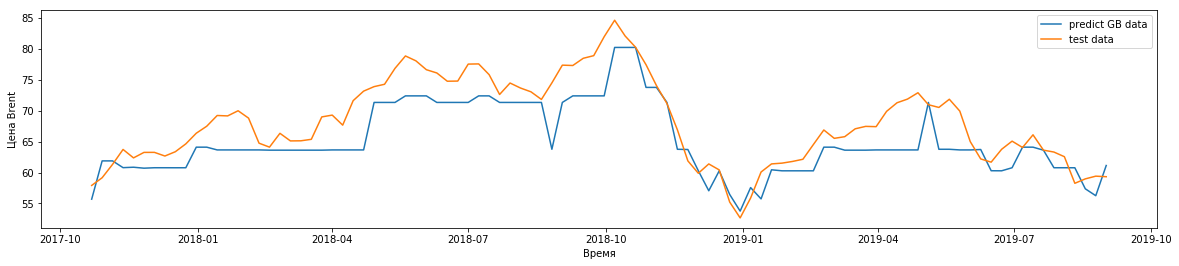

Ошибка градиентного бустинга :   4.893405044857613 %


In [98]:
model_gb_h1 = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
train_b, test_b = split_data_b( df_w, '10-10-2017')

h=1
X_train_b_h1 = train_b.iloc[:-h,:]
y_train_b_h1 = train_b[df_w.columns[0]].values[h:]
X_test_b_h1 = test_b.iloc[:-h,:]
y_test_b_h1 = test_b[df_w.columns[0]].values[h:]

model_gb_h1.fit( X_train_b_h1, y_train_b_h1 ) 
y_test_pred_gb_h1 = model_gb_h1.predict(X_test_b_h1)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],y_test_pred_gb_h1, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b_h1, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b_h1, y_pred=y_test_pred_gb_h1)

print('Ошибка градиентного бустинга :  ', er_g, '%')

In [101]:
er_s = mean_squared_error(y_true=y_test_b_h1, y_pred=y_test_pred_gb_h1) 
er_a = mean_absolute_error(y_true=y_test_b_h1, y_pred=y_test_pred_gb_h1) 
er_r2 = r2_score(y_true=y_test_b_h1, y_pred=y_test_pred_gb_h1)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   17.607065128429703 
ошибка mae  :   3.4252844698539806 
оценка R2 :   0.613828122334678


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [104]:
er_g = mean_absolute_percentage_error(y_true=y_test_b_h1+10, y_pred=y_test_pred_gb_h1+10)

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.2777235588473275 %


#### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [ ]:
R2 завышено, сложно определить зависимость цен на нефть и курсы валют (что является производной). Делаем вывод, что разности по валютам не сильно влияют на прогноз 